In [1]:
import pandas as pd
import requests as r
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from app import app
from utils.settings import DETERMINISTIC_MODELS, DETERMINISTIC_VARS, ENSEMBLE_VARS, ENSEMBLE_MODELS, DEFAULT_TEMPLATE
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
from utils.openmeteo_api import *
from utils.figures_utils import *
from pages.model_climate_daily.figures import make_prec_figure
import json
from PIL import Image

In [2]:
sun = get_forecast_daily_data(variables='sunrise,sunset',
                              forecast_days=14)

data = get_forecast_data(model='ecmwf_ifs04,icon_seamless,gfs_seamless',
                        forecast_days=7)

In [52]:
data = get_ensemble_data(
       model='gfs_seamless',
       variables="weather_code,temperature_2m,precipitation",
       from_now=False)

daily_tmin = data.loc[:,data.columns.str.contains('temperature_2m|time')].resample('1D', on='time').min()
daily_tmax = data.loc[:,data.columns.str.contains('temperature_2m|time')].resample('1D', on='time').max()
dail_wcode = data.loc[:,data.columns.str.contains('weather_code|time')].resample('1D', on='time').median()
daily_prec = data.loc[:,data.columns.str.contains('precipitation|time')].resample('1D', on='time').sum()

daily = daily_tmin.mean(axis=1).to_frame(name='t_min_mean')\
       .merge(daily_tmax.mean(axis=1).to_frame(name='t_max_mean'), left_index=True, right_index=True)\
       .merge(daily_tmin.min(axis=1).to_frame(name='t_min_min'), left_index=True, right_index=True)\
       .merge(daily_tmin.max(axis=1).to_frame(name='t_min_max'), left_index=True, right_index=True)\
       .merge(daily_tmax.max(axis=1).to_frame(name='t_max_max'), left_index=True, right_index=True)\
       .merge(daily_tmax.min(axis=1).to_frame(name='t_max_min'), left_index=True, right_index=True)\
       .merge(dail_wcode.mode(axis=1).astype(int).rename(columns={0:'weather_code'}), left_index=True, right_index=True)\
       .merge(daily_prec.mean(axis=1).to_frame(name='daily_prec_mean'), left_index=True, right_index=True)\
       .merge(daily_prec.quantile(0.25,axis=1).to_frame(name='daily_prec_min'), left_index=True, right_index=True)\
       .merge(daily_prec.quantile(0.75,axis=1).to_frame(name='daily_prec_max'), left_index=True, right_index=True)\
       .merge(((daily_prec[daily_prec > 0.1].count(axis=1) / daily_prec.shape[1]) * 100.).to_frame(name='prec_prob'), left_index=True, right_index=True)\

daily = get_weather_icons(daily)

In [54]:
daily

,t_min_mean,t_max_mean,t_min_min,t_min_max,t_max_max,t_max_min,weather_code,daily_prec_mean,daily_prec_min,daily_prec_max,prec_prob,icons,weather_descriptions
time,,,,,,,,,,,,,
2023-11-27 00:00:00+01:00,-0.180645,3.341935,-0.6,0.2,3.9,2.4,71,13.093548,10.85,15.75,100.000000,../src/assets/yrno_png/49.png,Light Snow
2023-11-28 00:00:00+01:00,-3.274194,0.577419,-4.8,-1.1,1.6,-0.5,3,1.580645,0.40,2.60,87.096774,../src/assets/yrno_png/03.png,Cloudy
2023-11-29 00:00:00+01:00,-3.683871,1.338710,-6.4,-1.0,2.9,0.2,71,7.987097,4.05,10.15,96.774194,../src/assets/yrno_png/49.png,Light Snow
2023-11-30 00:00:00+01:00,-3.987097,0.067742,-7.2,0.3,3.0,-2.3,3,1.967742,0.00,2.75,70.967742,../src/assets/yrno_png/03.png,Cloudy
2023-12-01 00:00:00+01:00,-2.535484,0.893548,-6.3,2.4,4.3,-1.5,3,7.964516,1.60,12.80,87.096774,../src/assets/yrno_png/03.png,Cloudy
2023-12-02 00:00:00+01:00,-3.293548,0.729032,-6.8,-0.4,3.5,-1.7,71,8.190323,1.70,10.35,93.548387,../src/assets/yrno_png/49.png,Light Snow
2023-12-03 00:00:00+01:00,-3.135484,1.164516,-7.2,0.4,2.9,-1.8,3,2.200000,0.20,3.30,77.419355,../src/assets/yrno_png/03.png,Cloudy
2023-12-04 00:00:00+01:00,-1.329032,1.916129,-5.1,1.6,4.7,-1.6,3,1.106452,0.00,0.95,64.516129,../src/assets/yrno_png/03.png,Cloudy
2023-12-05 00:00:00+01:00,-1.354839,1.864516,-5.4,4.1,8.1,-1.0,3,0.741935,0.00,0.75,48.387097,../src/assets/yrno_png/03.png,Cloudy



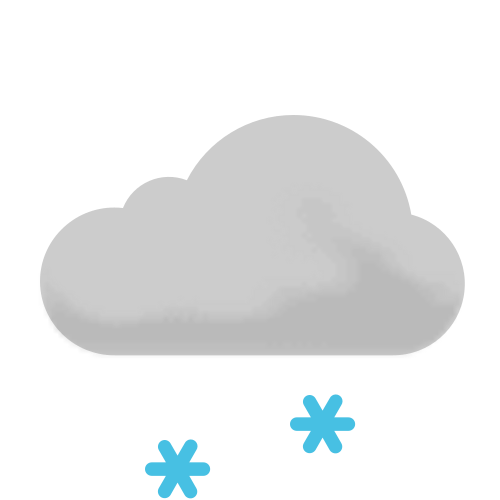
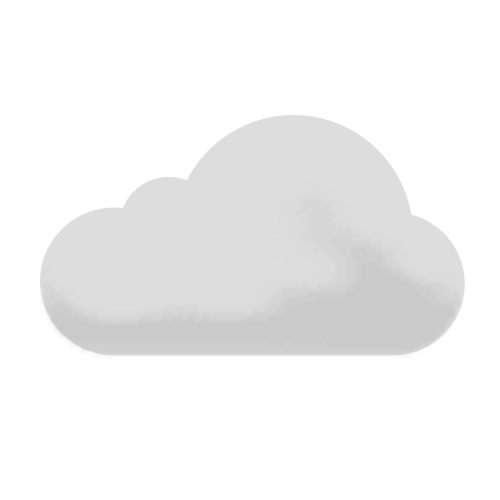
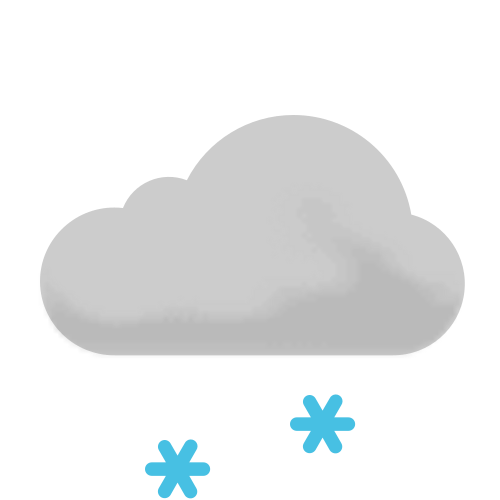
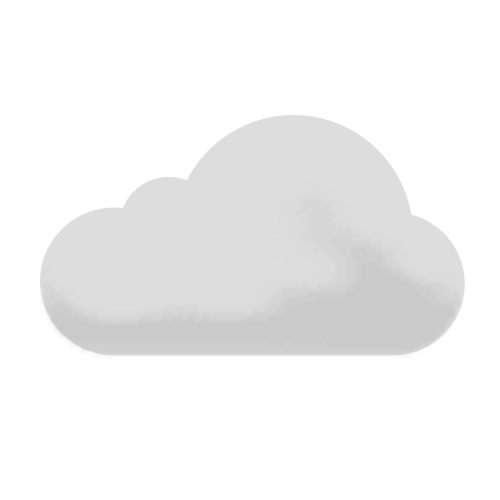
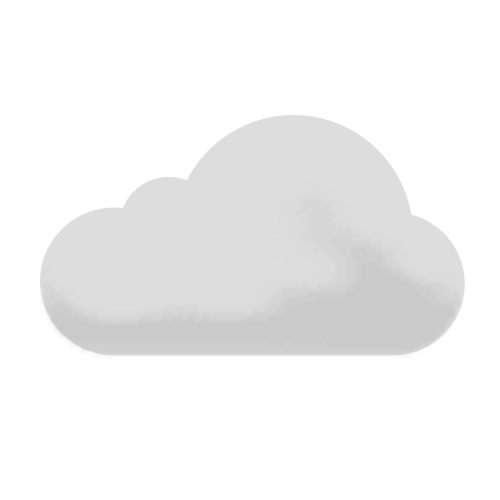
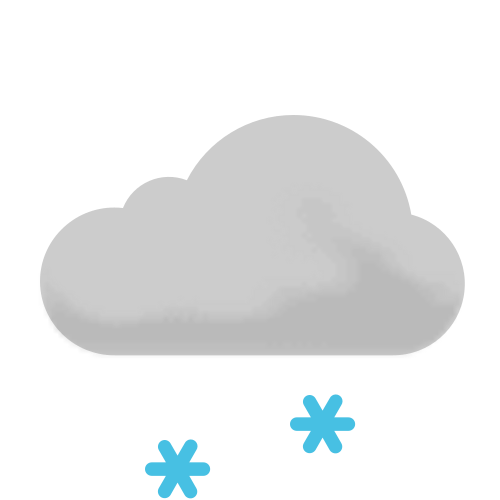
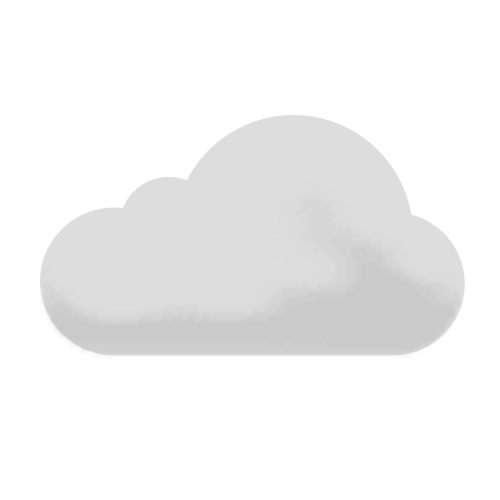
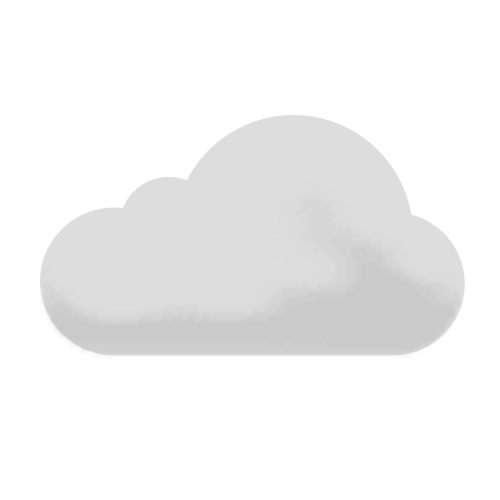
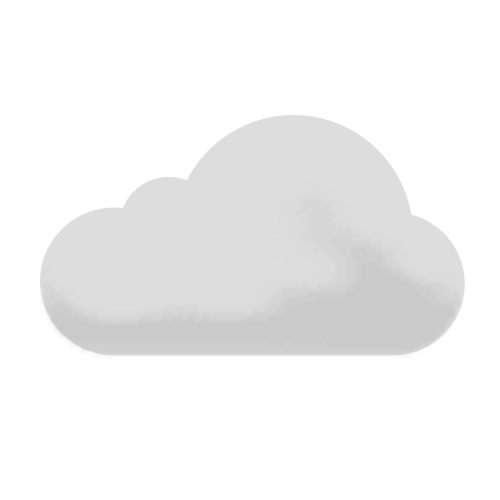
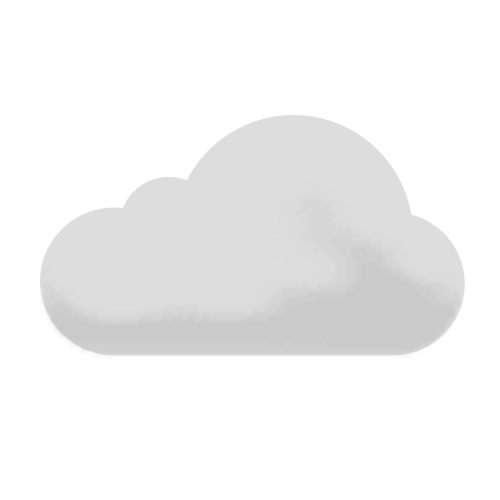
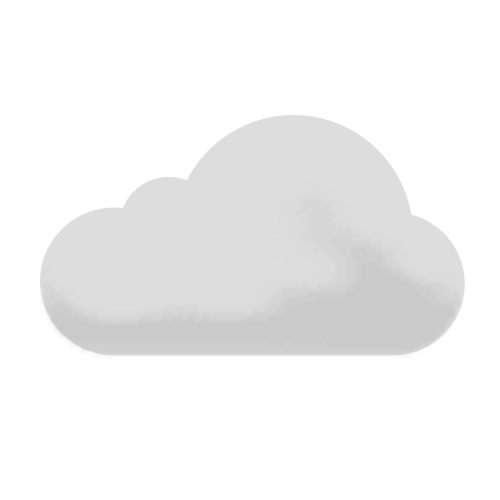
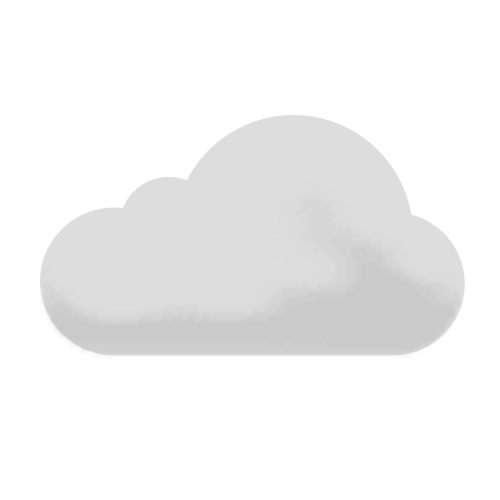
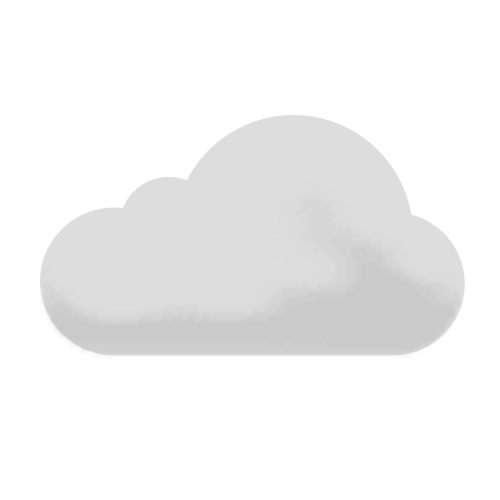
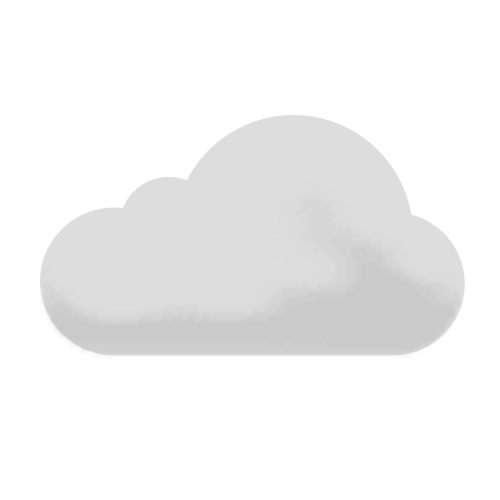

In [58]:
def make_temp_timeseries(df, showlegend=False):
    traces = []
    traces.append(
        go.Scatter(
            x=df['time'],
            y=df['t_max_mean'],
            mode='markers+lines+text',
            text=df['t_max_mean'].astype(int).astype(str) + ' °C',
            textposition="top right",
            textfont=dict(color='rgba(227, 56, 30, 1)'),
            name='Maximum temperature',
            line=dict(width=2, color='rgba(227, 56, 30, 1)'),
            showlegend=showlegend,),
    )
    traces.append(
        go.Scatter(
            x=df['time'],
            y=df['t_min_mean'],
            mode='markers+lines+text',
            text=df['t_min_mean'].astype(int).astype(str) + ' °C',
            textposition="top right",
            textfont=dict(color='rgba(58, 91, 139, 1)'),
            name='Minimum temperature',
            line=dict(width=2, color='rgba(58, 91, 139, 1)'),
            showlegend=showlegend),
    )
    traces.append(go.Scatter(
        x=df['time'],
        y=df['t_min_min'],
        mode='lines',
        line=dict(color='rgba(0, 0, 0, 0)'),
        name='',
        showlegend=False
    ))
    traces.append(go.Scatter(
        x=df['time'],
        y=df['t_min_max'],
        mode='lines',
        line=dict(color='rgba(0, 0, 0, 0)'),
        fillcolor='rgba(58, 91, 139, 0.2)',
        fill='tonexty',
        name='',
        showlegend=False
    ))
    traces.append(go.Scatter(
        x=df['time'],
        y=df['t_max_min'],
        mode='lines',
        line=dict(color='rgba(0, 0, 0, 0)'),
        name='',
        showlegend=False
    ))
    traces.append(go.Scatter(
        x=df['time'],
        y=df['t_max_max'],
        mode='lines',
        line=dict(color='rgba(0, 0, 0, 0)'),
        fillcolor='rgba(227, 56, 30, 0.2)',
        fill='tonexty',
        name='',
        showlegend=False
    ))
    return traces

def make_barplot_timeseries(df, showlegend=False):
    traces = []
    traces.append(go.Bar(
        x=df['time'],
        y=df['daily_prec_mean'],
        text=df['prec_prob'],
        name='',
        textposition='auto',
        texttemplate='%{text:.2s}%',
        showlegend=False,
        marker_color='rgb(73, 135, 230)'))

    return traces

def make_subplot_figure(data, title=None):
    traces_temp = make_temp_timeseries(data)
    traces_prec = make_barplot_timeseries(data)

    fig = make_subplots(
        rows=3,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        row_heights=[0.1, 0.5, 0.5],
        subplot_titles=['', '<b>Temperature<b>', '<b>Precipitation (mm) / Precipitation probability (%)<b>']
        )

    for trace_temp in traces_temp:
        fig.add_trace(trace_temp, row=2, col=1)
    for trace_prec in traces_prec:
        fig.add_trace(trace_prec, row=3, col=1)
    for _, row in data.iterrows():
        fig.add_shape(
            type='line',
            yref="y",
            xref="x",
            x0=row['time'],
            y0=row['daily_prec_min'],
            x1=row['time'],
            y1=row['daily_prec_max'],
            line=dict(color='rgba(0,0,0,0.3)', width=3),
            row=3, col=1)

    fig.add_trace(go.Scatter(
            x=data['time'],
            y=[3] * len(data['time']),
            mode='lines+text',
            text=data['time'].dt.strftime("<b>%a</b><br>%d %b"),
            textposition="top left",
            textfont=dict(color='rgba(1, 1, 1, 1)'),
            line=dict(color='rgba(0, 0, 0, 0)'),
            name='',
            showlegend=False
        ), row=1, col=1)
    for _, row in data.iterrows():
        fig.add_layout_image(dict(
            source=Image.open(row['icons']),
            xref='x',
            x=row['time'],
            yref='y',
            y=1,
            sizex=12*24*10*60*1000,
            sizey=2,
            xanchor="right",
            yanchor="bottom"
        ), row=1, col=1)

    fig.update_layout(
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True,),
        height=1000,
        margin={"r": 5, "t": 40, "l": 0.1, "b": 0.1},
        barmode='overlay',
        legend=dict(orientation='h', y=-0.04),
    )

    fig.update_yaxes(title_text="2m Temp [°C]", row=2, col=1)
    fig.update_yaxes(title_text="Prec.", row=3, col=1)
    fig.update_yaxes(showgrid=True, gridwidth=4)
    fig.update_xaxes(minor=dict(ticks="inside", showgrid=True,
                     gridwidth=1),
                     tickformat='%a %d %b\n%H:%M', showgrid=True, gridwidth=4)
        
    fig.update_yaxes(showgrid=False, row=1, col=1, minor=dict(showgrid=False),
                     range=[1, 6], showticklabels=False)
    fig.update_xaxes(showgrid=False, row=1, col=1, minor=dict(showgrid=False))
    if title is not None:
        fig.update_layout(title_text=title)

    return fig

make_subplot_figure(daily.reset_index())

In [ ]:
def make_lineplot_timeseries(df, var, models, mode='lines+markers', showlegend=False):
    traces = []
    # Define cyclical colors to be used
    colors = pio.templates[DEFAULT_TEMPLATE]['layout']['colorway'] * 5
    i = 0
    for model in models:
        if len(models) > 1:
            var_model = var + "_" + model
        else:
            var_model = var
        if var_model in df.columns:
            traces.append(
                go.Scatter(
                    x=df.loc[:, 'time'],
                    y=df.loc[:, var_model],
                    mode=mode,
                    name=model,
                    marker=dict(size=5, color=colors[i]),
                    line=dict(width=2, color=colors[i]),
                    showlegend=showlegend),
            )
        i += 1

    return traces


def make_windarrow_timeseries(df, models, var_speed='windgusts_10m', var_dir='winddirection_10m', showlegend=False):
    df = df[::6].copy()
    traces = []
    # Define cyclical colors to be used
    colors = pio.templates[DEFAULT_TEMPLATE]['layout']['colorway'] * 5
    i = 0
    for model in models:
        if len(models) > 1:
            var_speed_model = var_speed + "_" + model
            var_dir_model = var_dir + "_" + model
        else:
            var_speed_model = var_speed
            var_dir_model = var_dir
        if var_speed_model in df.columns and var_dir_model in df.columns:
            traces.append(
                go.Scatter(
                    x=df.loc[:, 'time'],
                    y=df.loc[:, var_speed_model],
                    mode='markers',
                    name=model,
                    marker=dict(size=10, color=colors[i],
                                symbol='arrow',
                                angle=df.loc[:, var_dir_model],
                                line=dict(width=1, color="DarkSlateGrey"),
                                ),
                    showlegend=showlegend),
            )
            # we always add to respect the colors order
        i += 1

    return traces


def make_barplot_timeseries(df, var, models):
    traces = []
    # Define cyclical colors to be used
    colors = pio.templates[DEFAULT_TEMPLATE]['layout']['colorway'] * 5
    i = 0
    for model in models:
        if len(models) > 1:
            var_model = var + "_" + model
        else:
            var_model = var
        if var_model in df.columns:
            traces.append(
                go.Bar(
                    x=df['time'],
                    y=df[var_model],
                    name=model,
                    opacity=0.6,
                    marker=dict(color='rgb(26, 118, 255)'),
                    showlegend=False),
            )
            traces.append(
                go.Scatter(
                    x=df.loc[df[var_model] >= 0.1, 'time'],
                    y=df.loc[df[var_model] >= 0.1, var_model],
                    mode='markers',
                    name=model,
                    marker=dict(size=3, color=colors[i]),
                    showlegend=False),
            )
        i += 1

    return traces


def add_weather_icons(data, fig, row_fig, col_fig, var, models):
    from PIL import Image
    from utils.figures_utils import get_weather_icons
    for model in models:
        if len(models) > 1:
            var_model = var + "_" + model
            var_weather_model = "weather_code_" + model
        else:
            var_weather_model = 'weather_code'
            var_model = var
        if var_weather_model in data:
            data = data.resample('12H', on='time').max().reset_index()
            data = get_weather_icons(data,
                                     var=var_weather_model,
                                     icons_path="../src/assets/yrno_png/",
                                     mapping_path="../src/assets/weather_codes.json")
            for _, row in data.iterrows():
                fig.add_layout_image(dict(
                    source=Image.open(row['icons']),
                    xref='x',
                    x=row['time'],
                    yref='y',
                    y=row[var_model],
                    sizex=12*24*10*60*1000,
                    sizey=1,
                    # xanchor="center",
                    # yanchor="bottom"
                ),row=row_fig, col=col_fig)



def make_subplot_figure(data, models, title=None, sun=None):
    traces_temp = make_lineplot_timeseries(
        data, 'temperature_2m', showlegend=True, models=models)
    traces_precipitation = make_barplot_timeseries(data, 'precipitation', models=models)
    traces_wind = make_lineplot_timeseries(data, 'windgusts_10m', mode='lines', models=models)
    traces_wind_dir = make_windarrow_timeseries(data, models=models)
    traces_cloud = make_lineplot_timeseries(data, 'cloudcover', mode='markers', models=models)

    fig = make_subplots(
        rows=4,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.5, 0.3, 0.3, 0.3])

    for trace_temp in traces_temp:
        fig.add_trace(trace_temp, row=1, col=1)
        # add_weather_icons(data, fig=fig, row_fig=1, col_fig=1, var='temperature_2m', models=models)
        fig.add_hline(y=0, line_width=3, row=1, col=1,
                      line_color="rgba(0,0,0,0.05)")  # 0 isotherm
    for trace_precipitation in traces_precipitation:
        fig.add_trace(trace_precipitation, row=2, col=1)
    for trace_wind in traces_wind:
        fig.add_trace(trace_wind, row=3, col=1)
    for trace_wind_dir in traces_wind_dir:
        fig.add_trace(trace_wind_dir, row=3, col=1)
    for trace_cloud in traces_cloud:
        fig.add_trace(trace_cloud, row=4, col=1)

    fig.update_layout(
        xaxis=dict(showgrid=True,
                   range=[data['time'].min(),
                          data['time'].max()]),
        yaxis=dict(showgrid=True,),
        height=1000,
        margin={"r": 5, "t": 40, "l": 0.1, "b": 0.1},
        barmode='overlay',
        legend=dict(orientation='h', y=-0.04),
    )

    if sun is not None:
        for i, s in sun.iterrows():
            fig.add_vrect(
                x0=s['sunrise'],
                x1=s['sunset'],
                fillcolor="rgba(255, 255, 0, 0.3)",
                layer="below",
                line=dict(width=0),
                row=1, col=1
            )

    fig.update_yaxes(title_text="2m Temp [°C]", row=1, col=1)
    fig.update_yaxes(title_text="Prec. [mm]", row=2, col=1)
    fig.update_yaxes(title_text="Wind Gusts [kph]", row=3, col=1)
    fig.update_yaxes(title_text="Cloud cover [%]", row=4, col=1)
    fig.update_yaxes(showgrid=True, gridwidth=4)
    fig.update_xaxes(minor=dict(ticks="inside", showgrid=True,
                     gridwidth=1),
                     tickformat='%a %d %b\n%H:%M', showgrid=True, gridwidth=4)
    if title is not None:
        fig.update_layout(title_text=title)

    return fig

make_subplot_figure(data, sun=sun, models=['ecmwf_ifs04','icon_seamless','gfs_seamless'])